<a href="https://colab.research.google.com/github/SushilKokare/University_Project/blob/Keras_Applications_Modified/Ensemble_1_and_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten, Dropout, Input, Average, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import BatchNormalization, MaxPooling2D
from keras import backend as k 
from matplotlib import pyplot as plt

In [ ]:
from keras.applications.xception import Xception
from keras.applications.resnet_v2 import ResNet101V2

In [ ]:
def prepro_data(pathTrain,pathTest,img_size,batch_size):
  
  if k.image_data_format() == 'channels_first':
    input_shape = (3,img_size[0],img_size[1])
  else:
    input_shape = (img_size[0],img_size[1],3)

  train_gen = ImageDataGenerator(rescale = 1./255)
  test_gen = ImageDataGenerator(rescale = 1./255)

  train_data = train_gen.flow_from_directory(
      pathTrain,
      target_size = img_size,
      # batch_size = batch_size,
      class_mode = 'binary'
  ) 

  test_data = test_gen.flow_from_directory(
      pathTest,
      target_size = img_size,
      # batch_size = batch_size,
      class_mode = 'binary'
  )

  print(" Train Data Image Shape = {}".format(train_data.image_shape))
  print(" Test Data Image Shape = {}".format(test_data.image_shape))
  print("Input Shape = {} ".format(input_shape))

  return train_data , test_data , input_shape

In [ ]:

def show_result(history):
  plt.figure(figsize=(5,3))
  plt.title("Loss Training Vs Validation")
  plt.plot(history.history['loss'],color='blue',label='Train Loss')
  plt.plot(history.history['val_loss'],color='orange',label='Val Loss')
  plt.legend()
  plt.show()

  plt.figure(figsize=(5,3))
  plt.title("Accuracy Training Vs Validation")
  plt.plot(history.history['accuracy'],color='blue',label='Train Acc')
  plt.plot(history.history['val_accuracy'],color='orange',label='Val Acc')
  plt.legend()
  plt.show()

In [ ]:
pathTrain = '/content/drive/MyDrive/AtiNeu Project/Data/MRI/Brain_Data_Organised/Train'
pathTest = '/content/drive/MyDrive/AtiNeu Project/Data/MRI/Brain_Data_Organised/Test'
 

In [ ]:
train_data , test_data, input_shape = prepro_data(pathTrain,pathTest,(225,225),32)


Found 2251 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
 Train Data Image Shape = (225, 225, 3)
 Test Data Image Shape = (225, 225, 3)
Input Shape = (225, 225, 3) 


In [ ]:

base_model_Xception = Xception(weights = 'imagenet',include_top = False,
                      input_shape = input_shape)
     

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
# Freeze  the first 10 layers
for layer in base_model_Xception.layers[:10]:
  layer.trainable = False

x = base_model_Xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1,activation='sigmoid')(x)

model1 = Model(inputs = base_model_Xception.inputs, outputs = predictions)
    

In [ ]:
base_model_ResNet101V2 = ResNet101V2(weights = 'imagenet',include_top = False,
                      input_shape = input_shape)

171317808/171317808 [==============================] - 6s 0us/step


In [ ]:
for layer in base_model_ResNet101V2.layers[:10]:
  layer.trainable = False

x = base_model_ResNet101V2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1,activation='sigmoid')(x)

model2 = Model(inputs = base_model_ResNet101V2.inputs, outputs = predictions)

In [ ]:

from keras.callbacks import ModelCheckpoint

In [ ]:

# checkpoint to save best model per epoch

model_filepath = '/content/drive/MyDrive/AtiNeu Project/Ensemble_model-{epoch:02d} - {val_accuracy: .4f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [ ]:

model1.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:

model2.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_data,epochs=10,validation_data=test_data,
                    )
     

Epoch 1/10
71/71 [==============================] - 1111s 15s/step - loss: 0.5672 - accuracy: 0.6570 - val_loss: 1.9006 - val_accuracy: 0.5480
Epoch 2/10
71/71 [==============================] - 30s 415ms/step - loss: 0.3870 - accuracy: 0.8210 - val_loss: 3.3461 - val_accuracy: 0.8480
Epoch 3/10
71/71 [==============================] - 30s 423ms/step - loss: 0.2551 - accuracy: 0.8992 - val_loss: 4.0404 - val_accuracy: 0.6840
Epoch 4/10
71/71 [==============================] - 30s 425ms/step - loss: 0.1533 - accuracy: 0.9387 - val_loss: 2.1825 - val_accuracy: 0.8280
Epoch 5/10
71/71 [==============================] - 32s 451ms/step - loss: 0.0946 - accuracy: 0.9689 - val_loss: 2.3960 - val_accuracy: 0.6960
Epoch 6/10
71/71 [==============================] - 31s 437ms/step - loss: 0.2299 - accuracy: 0.9156 - val_loss: 0.5574 - val_accuracy: 0.8120
Epoch 7/10
71/71 [==============================] - 31s 440ms/step - loss: 0.0944 - accuracy: 0.9640 - val_loss: 2.8379 - val_accuracy: 0.6680

In [ ]:
model1.save('/content/drive/MyDrive/AtiNeu Project/Xception_val_acc_8640.h5')

In [ ]:
history2 = model2.fit(train_data,epochs=10,validation_data=test_data,
                    )
     

Epoch 1/10
71/71 [==============================] - 119s 632ms/step - loss: 0.6251 - accuracy: 0.6384 - val_loss: 1876197632.0000 - val_accuracy: 0.5000
Epoch 2/10
71/71 [==============================] - 40s 560ms/step - loss: 0.5976 - accuracy: 0.6490 - val_loss: 196109.4219 - val_accuracy: 0.5000
Epoch 3/10
71/71 [==============================] - 40s 563ms/step - loss: 0.5611 - accuracy: 0.6837 - val_loss: 9184.6826 - val_accuracy: 0.5000
Epoch 4/10
71/71 [==============================] - 40s 568ms/step - loss: 0.5200 - accuracy: 0.7095 - val_loss: 29.2988 - val_accuracy: 0.5280
Epoch 5/10
71/71 [==============================] - 41s 572ms/step - loss: 0.5129 - accuracy: 0.7192 - val_loss: 1.4554 - val_accuracy: 0.5960
Epoch 6/10
71/71 [==============================] - 41s 574ms/step - loss: 0.4893 - accuracy: 0.7454 - val_loss: 117.8230 - val_accuracy: 0.5000
Epoch 7/10
71/71 [==============================] - 41s 577ms/step - loss: 0.4514 - accuracy: 0.7752 - val_loss: 6320.491

In [ ]:
# model1.save('/content/drive/MyDrive/AtiNeu Project/ResNet101V2_val_acc_.h5')

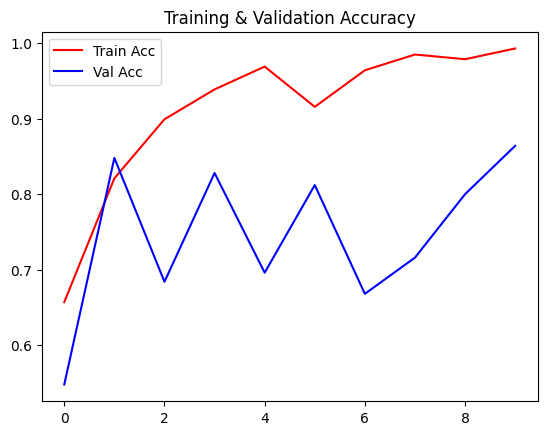

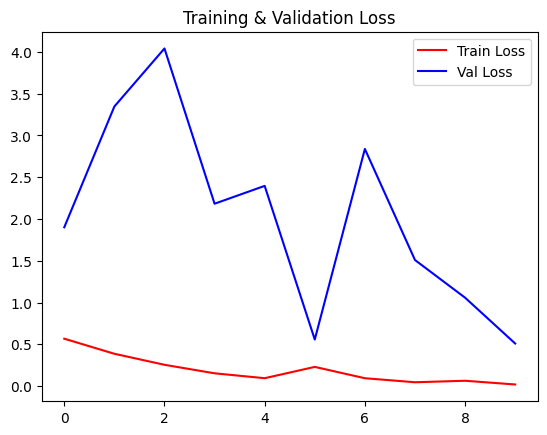

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Train Acc')
plt.plot(epochs,val_acc,'b',label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Val Loss')
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

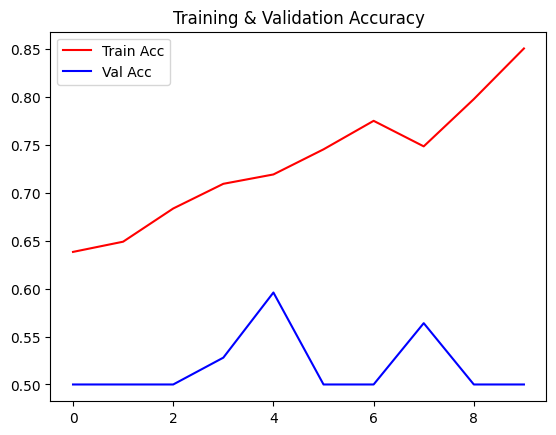

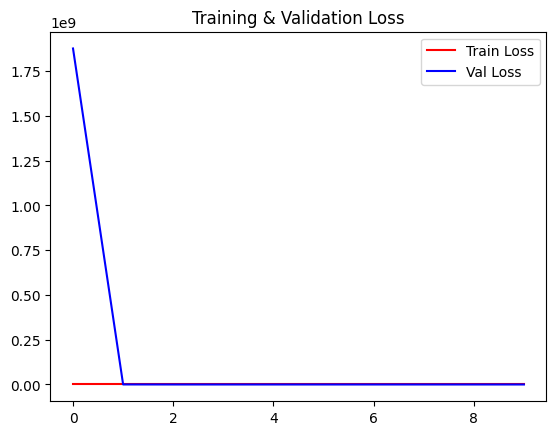

In [ ]:

import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Train Acc')
plt.plot(epochs,val_acc,'b',label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Val Loss')
plt.title("Training & Validation Loss")
plt.legend()

plt.show()
     

In [ ]:

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Average